How different feature extraction methods affect the effectiveness of classification?

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [27]:
def paths_to_dataframe(path):
    labels = []
    for i in range(len(path)):
        labels.append(str(path[i]).split(os.sep)[-2])

    labels = pd.Series(labels, name='Label')
    path = pd.Series(path, name='Path').astype(str)

    df = pd.concat([path, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df
    
train_df = paths_to_dataframe(train_filepaths)
test_df = paths_to_dataframe(test_filepaths)
val_df = paths_to_dataframe(val_filepaths)

test_df.head()
print()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(classification_rep)

    classes = np.unique(y_test)
    class_accuracy = {}
    for cls in classes:
        indices = np.where(y_test == cls)[0]
        class_accuracy[cls] = accuracy_score(y_test[indices], np.array(y_pred)[indices])

    return accuracy, precision, recall, f1, class_accuracy

In [37]:
from sklearn.tree import DecisionTreeClassifier

def nested_dichotomy(X_train, y_train, X_test):
    unique_labels = np.unique(y_train)
    num_classes = len(unique_labels)
    classifiers = []
    classified_indices = np.full(len(X_train), False)

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train, y_binary)
        classifiers.append((tree, i))
        print(i)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = ['tomato' for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None:
                results[j] = unique_labels[i]
        

    return results, predictions, classifiers

In [38]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

y_test = test_df['Label']
y_train = train_df['Label']

In [39]:
vgg16_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
X_train_vgg16 = np.array([extract_features(img_path, vgg16_model) for img_path in train_df['Path']])
X_test_vgg16 = np.array([extract_features(img_path, vgg16_model) for img_path in test_df['Path']])
results_vgg16, pred_vgg16, models_vgg16 = nested_dichotomy(X_train_vgg16, y_train, X_test_vgg16)
accuracy_vgg16, precision_vgg16, recall_vgg16, f1_vgg16, class_accuracy_vgg16 = metrics(y_test, results_vgg16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━

In [42]:
from tensorflow.keras.applications import InceptionV3

inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
X_train_inception = np.array([extract_features(img_path, inception_model) for img_path in train_df['Path']])
X_test_inception = np.array([extract_features(img_path, inception_model) for img_path in test_df['Path']])
results_inception, pred_inception, models_inception = nested_dichotomy(X_train_inception, y_train, X_test_inception)
accuracy_inception, precision_inception, recall_inception, f1_inception, class_accuracy_inception = metrics(y_test, results_inception)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/ste

In [43]:
from tensorflow.keras.applications import MobileNetV2

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
X_train_mobilenet = np.array([extract_features(img_path, mobilenet_model) for img_path in train_df['Path']])
X_test_mobilenet = np.array([extract_features(img_path, mobilenet_model) for img_path in test_df['Path']])
results_mobilenet, pred_mobilenet, models_mobilenet = nested_dichotomy(X_train_mobilenet, y_train, X_test_mobilenet)
accuracy_mobilenet, precision_mobilenet, recall_mobilenet, f1_mobilenet, class_accuracy_mobilenet = metrics(y_test, results_mobilenet)

/var/folders/kb/21stffp561n7vlhn9h_r55zc0000gn/T/ipykernel_45919/2179455481.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

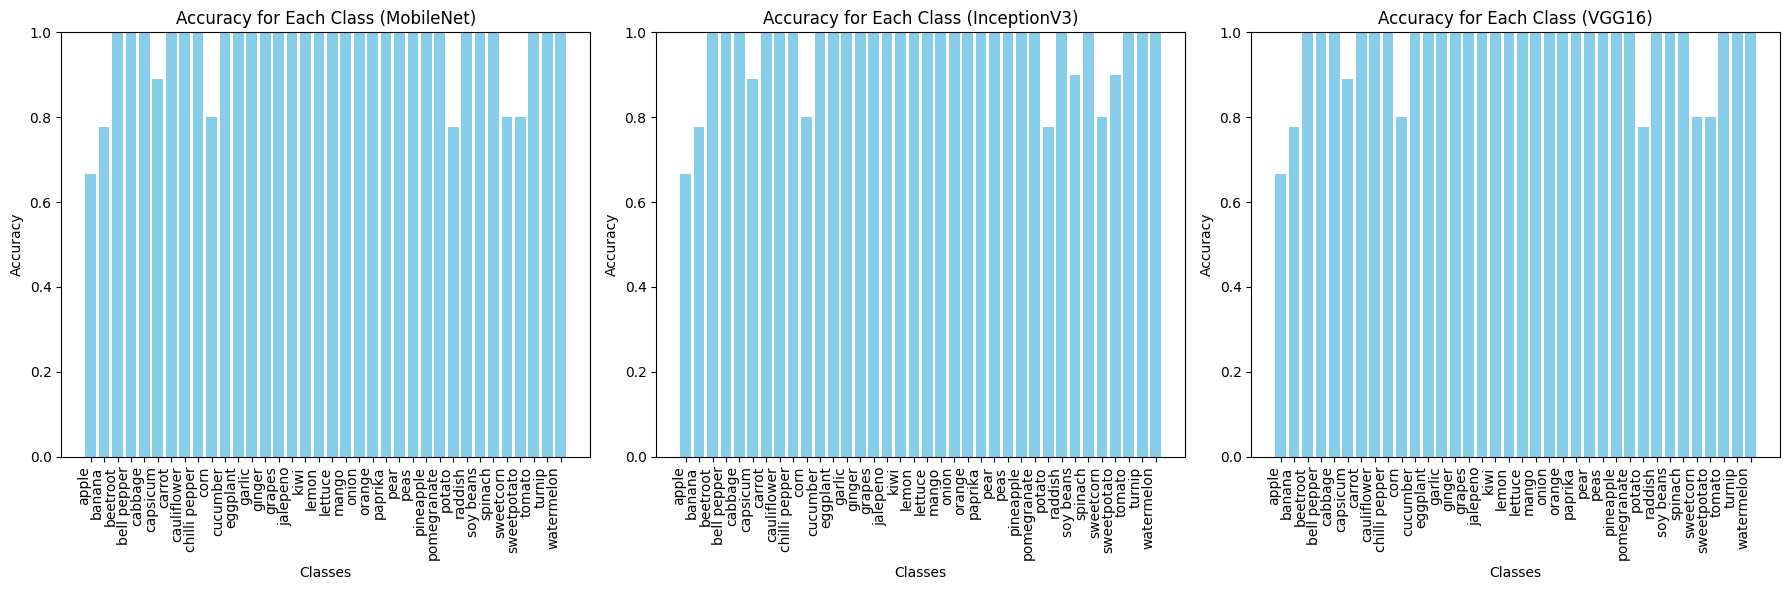

In [52]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(class_accuracy_mobilenet.keys(), class_accuracy_mobilenet.values(), color='skyblue')
plt.title('Accuracy for Each Class (MobileNet)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.bar(class_accuracy_inception.keys(), class_accuracy_inception.values(), color='skyblue')
plt.title('Accuracy for Each Class (InceptionV3)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.bar(class_accuracy_vgg16.keys(), class_accuracy_vgg16.values(), color='skyblue')
plt.title('Accuracy for Each Class (VGG16)')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

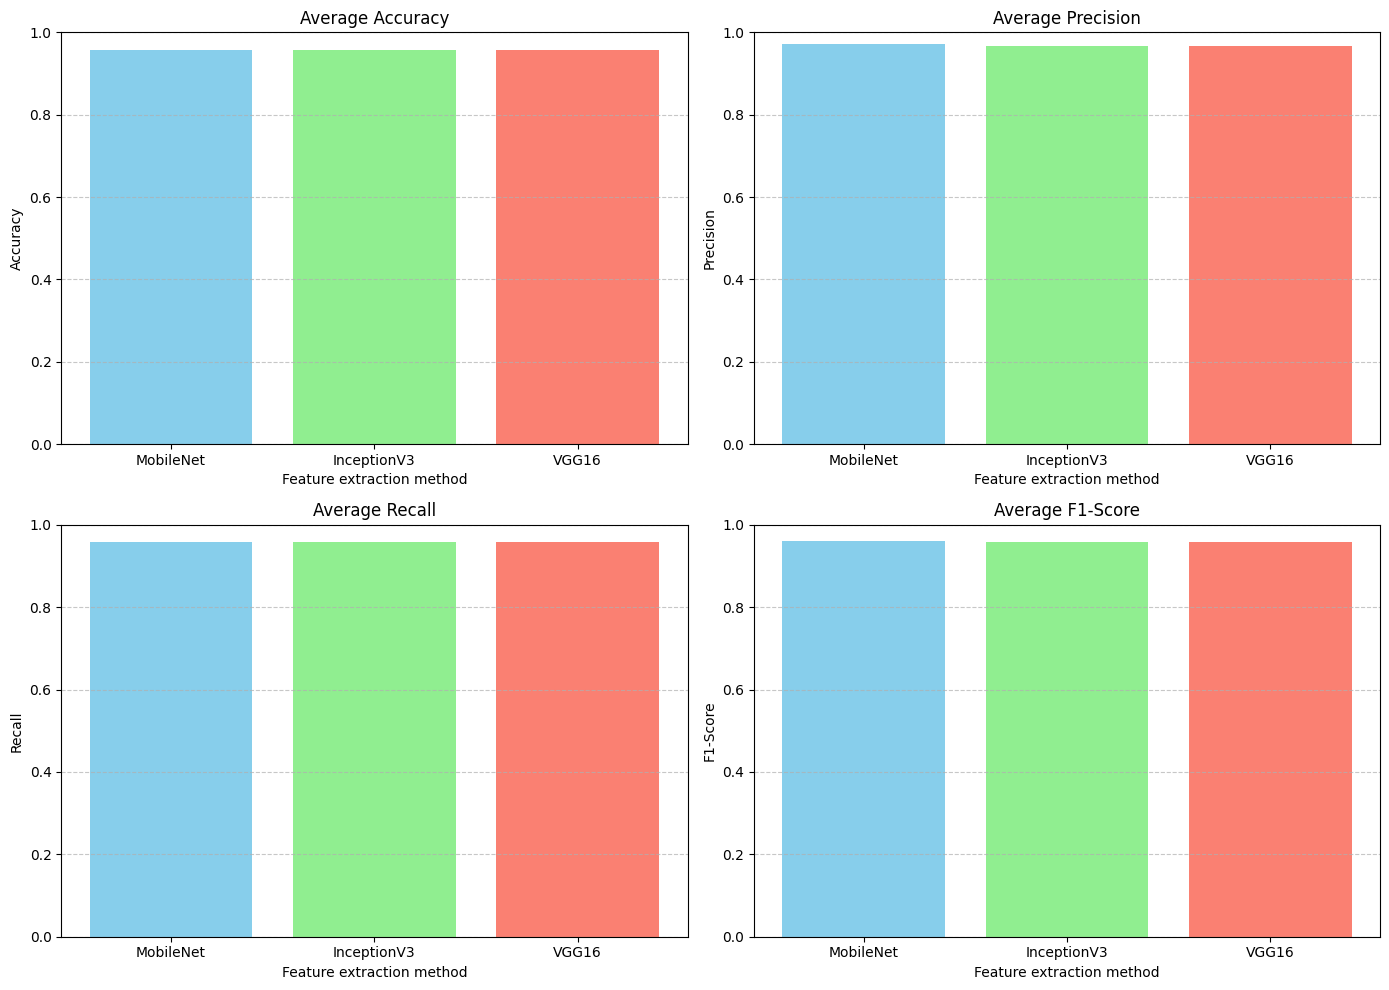

In [51]:
import matplotlib.pyplot as plt

methods = ['MobileNet', 'InceptionV3', 'VGG16']
accuracies = [accuracy_mobilenet, accuracy_inception, accuracy_vgg16]
precisions = [precision_mobilenet, precision_inception, precision_vgg16]
recalls = [recall_mobilenet, recall_inception, recall_vgg16]
f1_scores = [f1_mobilenet, f1_inception, f1_vgg16]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Accuracy')
plt.xlabel('Feature extraction method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
plt.bar(methods, precisions, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Precision')
plt.xlabel('Feature extraction method')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.bar(methods, recalls, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Recall')
plt.xlabel('Feature extraction method')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
plt.bar(methods, f1_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average F1-Score')
plt.xlabel('Feature extraction method')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()